# Performance/Cost Assessment of EC2 Types Using Dask
## Downscale MUR SST 1 km files via an EC2 instance, accessing S3 buckets and utilizing dask parallel computing

This notebook is a first demonstration of functions and workflow. MUR 1 km files are accessed via S3, downscaled to 100 km resolution over the entire globe, and saved as .nc files in a new folder. 

Uses the MUR Level 4 daily SST ultra high resolution data product, 0.01 degree resolution:
* product information: https://doi.org/10.5067/GHGMR-4FJ04
* s3 location `s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/`.

<br>

**Requirements to run this notebook**
* Run from an AWS EC2 instance (bare minimum of t2.xlarge recommended).
* Have a URS Earthdata login, with login credentials placed in the `.netrc` file on the home directory of the instance:
```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```
* In addition to installing the python modules imported below, the `h5netcdf` and `netCDF4` python modules need to be installed (backends used by `xarray`).

<br>

**Other notes**
* Seems like a minimum of a t2.xlarge instance (8 GB RAM) is required.
* ***Garbage collection and variable deletion is essential. EC2 instance runs out of RAM otherwise.***

<br>


In [1]:
import gc
import os
import shutil

import s3fs
import requests

import xarray as xr
import numpy as np
import pandas as pd

import multiprocessing
import dask.array as da
from dask import delayed
from dask.distributed import Client

import matplotlib.pyplot as plt
%matplotlib inline

## Establish S3 connection and obtain MUR file paths
**!!** If code blocks in this section fail, ensure that the requirements to run this notebook listed in the beginning have been met, specifically the .netrc file.

In [2]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and uses it 
    to obtain a temporary AWS S3 credential through a podaac service accessable at 
    https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    s3: an AWS S3 filesystem
    """
    import requests, s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'],
                           client_kwargs={'region_name':'us-west-2'})
    return s3

In [3]:
# Get temporary AWS credentials for access
fs_s3 = init_S3FileSystem()

In [4]:
# Check that S3 connection was successful:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")
print("total files found = ",len(fns))
print("Example filename: ", fns[0])

total files found =  7707
Example filename:  podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


## Function to load and downscale MUR SST files

In [6]:
def downscale_xr_s3(fs_s3, filepath_s3, output_dir, chunks=None):
    """
    Open and downscale SST's from 1 km to 100 km from a MUR 1 km file on an 
    S3 bucket. fs_s3 is the S3 file system and filepath_s3 is the MUR 
    filepath on S3. output_dir is the directory to save the downscaled 
    data file in.
    """
    
    # Open file:
    s3_file_obj = fs_s3.open(filepath_s3, mode='rb')
    sstdata = xr.open_dataset(
        s3_file_obj, chunks=chunks, 
        drop_variables=['analysis_error', 'mask', 'sea_ice_fraction', 'dt_1km_data', 'sst_anomaly']
        )
        
    
    # Compute downscaled SST field:
    def downscale_mursst(sst):
        """
        This function takes MUR SST 1km data (with dimensions of 17900x36000), reshapes, 
        computes the mean temperature in 100 km x 100 km boxes, and then returns the processed 
        SST data (shape 180x360).

        Parameters
        ----------
        sst: 2D array-like of sea surface temperatures.
        """
        sst0 = np.r_[sst[0:1, :], sst]; del sst
        sst = sst0.reshape(180, 100, 360, 100).mean(axis=-1).mean(axis=1); del sst0
        return sst
    
    sst_downscaled = downscale_mursst(sstdata['analysed_sst'][0, ...])
    
    
    # Save downscaled SST to .nc file:
    ds = xr.Dataset(
        data_vars=dict(
            analysed_sst=(["time", "lat", "lon"], np.expand_dims(sst_downscaled, axis=0)) # Add dim for time.
            ),
        coords=dict(
            lon=sstdata['lon'].values[::100], # lons, lats in downscaled res.
            lat=sstdata['lat'].values[::100],
            time=sstdata["time"].values,
            ),
        attrs=dict(
            description="SST downscaled from MUR 1 km file to 100 km resolution.",
            units="K",
            ),
        )
    ds.to_netcdf(output_dir + filepath_s3.split("/")[-1][:-3] + "_downscaled.nc")
    
    sstdata.close()

## Control: Downscale 10 files without Dask

Directory to save downscaled files in:

In [7]:
dir_downscaled = "./sst_downscaled/"
if os.path.exists(dir_downscaled):
    shutil.rmtree(dir_downscaled)
os.mkdir(dir_downscaled)

Downscale files. **This block will take 4-5 minutes to complete**

In [8]:
%%time
for i in range(10):
    downscale_xr_s3(fs_s3, fns[i], dir_downscaled)

CPU times: user 1min 25s, sys: 27.3 s, total: 1min 52s
Wall time: 4min 15s


## Test: Downscale 10 files with Basic Dask Parallelization and 10 Workers

**Clear output folder**

In [59]:
files_rm = [f for f in os.listdir(dir_downscaled) if f.endswith(".nc")]
for f in files_rm:
    os.remove(dir_downscaled + f)

**Setup Dask cluster**

In [8]:
# Just to see, print available vCPUs on this machine:
print(multiprocessing.cpu_count())

48


In [60]:
client = Client(n_workers=10, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 48,Total memory: 373.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36911,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 373.71 GiB
Comm: tcp://127.0.0.1:42091,Total threads: 2
Dashboard: http://127.0.0.1:46453/status,Memory: 15.57 GiB
Nanny: tcp://127.0.0.1:37881,


**Parallelize downscaling function and run computation on 10 files**

The client may product memory warning messages but the computations will still complete.

In [61]:
# Wrap the process_granule function with dask.delayed
delayed_downscale = delayed(downscale_xr_s3)

In [62]:
%%time
# Process all granules in parallel using Dask
dscale_tasks = [
    delayed_downscale(fs_s3, fn, dir_downscaled) 
    for fn in fns[:10]
    ]
_ = da.compute(*dscale_tasks)

CPU times: user 3.48 s, sys: 696 ms, total: 4.17 s
Wall time: 33.3 s


In [63]:
client.close()

Check output folder contents

In [10]:
fnames_dscaled = [f for f in os.listdir("./sst_downscaled/") if "_downscaled" in f]
fnames_dscaled.sort()
fnames_dscaled

['20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020608090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020609090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc',
 '20020610090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_downscaled.nc']

## Plot one of the output files

Load 1 km and 100 km files for same day

In [20]:
murfile_1km = xr.open_dataset(fs_s3.open(fns[0], mode='rb'))
murfile_100km = xr.open_dataset("./sst_downscaled/" + fnames_dscaled[0])

Subset to Eastern Pacific Region (Tropical to Mid-latitude)

In [23]:
murfile_1km = murfile_1km.sel(lat=slice(-45,45), lon=slice(-180, -50))
murfile_100km = murfile_100km.sel(lat=slice(-45,45), lon=slice(-180, -50))

Plot

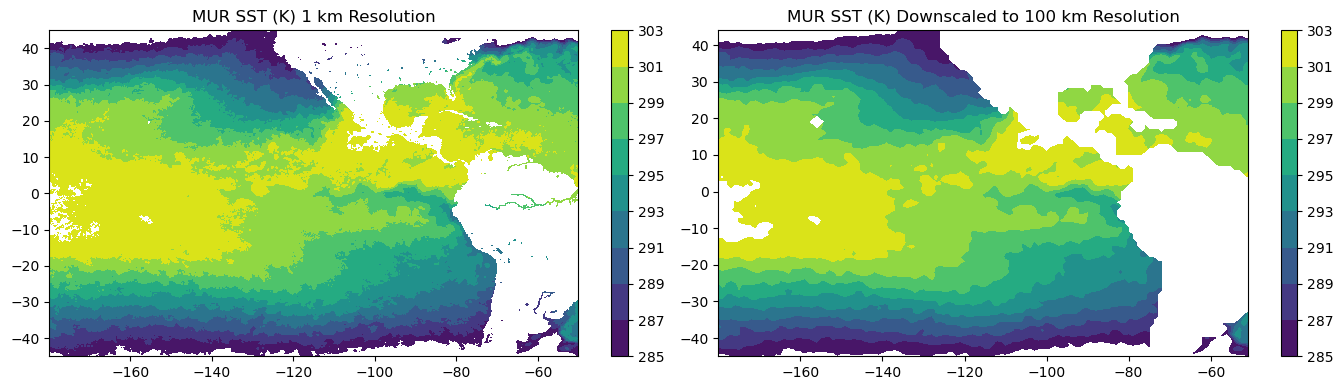

In [26]:
clevs = np.arange(285, 305, 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), layout='tight')
cp0 = axes[0].contourf(murfile_1km['lon'], murfile_1km['lat'], murfile_1km['analysed_sst'].squeeze(), levels=clevs)
cp1 = axes[1].contourf(murfile_100km['lon'], murfile_100km['lat'], murfile_100km['analysed_sst'].squeeze(), levels=clevs)
fig.colorbar(cp0, ax=axes[0])
fig.colorbar(cp1, ax=axes[1])

axes[0].set_title("MUR SST (K) 1 km Resolution", fontsize=12)
axes[1].set_title("MUR SST (K) Downscaled to 100 km Resolution", fontsize=12)

fig.savefig("example_downscaling.png")

### Other important things to consider

* The memory per worker is important for completing the computation. That is, **you need to make sure the memory requirement for analyzing a single file is less the the memory per worker** (number of workers you specify divided by the total memory of the EC2 instance). As a reference, **the MUR 1 km files are ~700 MB each and the downscaling function required ~5.5 GB of memory to process a single file.** 
* The `drop_variables` argument for xarray's `open_dataset()` apparently did not reduce the memory requirements per worker nor did it decrease computation times.
* This analysis did not consider chunking.

### Comparison of EC2 types

This section does not run any code but provides a comparison of computation times and costs across several EC2 types running the above downscaling function. The scripts/notebooks used to generate the figures can be found in the ancillary folder.


| AWS-Defined EC2 Category  | EC2 Instance Type  | Max vCPUs <br/>(workers)  | Total Memory <br/>(GiB)  | Linux On-Demand <br/>Hourly Rate |   Other Notes from AWS |
|--------------------------:|:-------------------|:-----|:------|:------|:---|
| **General Purpose**       | t2.large           | 2    | 8     | \\$0.0928 | **Balance of compute, memory, and network resources.** <br/><br/>Burstable Performance Instances that provide a baseline level of CPU performance with the ability to burst above the baseline. <br/><br/>High frequency Intel Xeon processors  |
| **Compute Optimized**     | c6i.32xlarge       | 128  | 256   | \\$5.44   | **Compute Optimized instances are ideal for compute bound applications that benefit from high performance processors.** <br/><br/>Powered by 3rd generation Intel Xeon Scalable processors and are an ideal fit for compute-intensive workloads. <br/><br/>Powered by the AWS Nitro System, a combination of dedicated hardware and lightweight hypervisor. |
| **Memory Optimized**      | r5.12xlarge        | 48   | 384   | \\$3.024  | **Memory optimized instances are designed to deliver fast performance for workloads that process large data sets in memory.** <br/><br/>Up to 3.1 GHz Intel Xeon® Platinum 8000 series processors (Skylake 8175M or Cascade Lake 8259CL) with new Intel Advanced Vector Extension (AVX-512) instruction set. <br/><br/>Powered by the AWS Nitro System, a combination of dedicated hardware and lightweight hypervisor.|
|                           | r5n.12xlarge       | 48   | 384   | \\$3.576  | Similar to r5.12xlarge but with 5x networking speed. |
| **Accelerated Computing** | p2.8xlarge         | 32   | 488   | \\$7.20   | **Accelerated computing instances use hardware accelerators, or co-processors, to perform functions, such as floating point number calculations, graphics processing, or data pattern matching, more efficiently than is possible in software running on CPUs.** <br/><br/>2.3 GHz (base) and 2.7 GHz (turbo) Intel Xeon E5-2686 v4 Processor.|


The left panel in Figure 1 compares sequential vs. parallel computation for the downscaling function, using the r5.12xlarge instance. ***Computation times for 1000 files are cut from ~8 hrs to ~15 minutes***. The right panel of Figure 2 shows the results of parallelizing and running the downscaling function on 4 different EC2 types.
* For the instances used with parallel computing, the *memory optimized* instances (r5.12xlarge and r5n.12xlarge) processed 1000 files the quickest and cost the least. In fact, processing 1000 files cost about as much as it would for an extremely small instance (t2.large) and took 15 minutes rather than 8 hrs.
* The *compute optimized* instance (c6i.32xlarge) had to be run with only 30 workers rather than the full 128 workers in order for each worker to have enough memory to process a single file. Despite this, it processed 1000 files at about the same time as the *memory optimized* instance. This suggests that for analyses which need to analyze many small files, the *compute optimized* instances may be the best option, since more of their workers could be used.
* The *accelerated computing* instance (p2.8xlarge) completed processing the slowest, although it costs the most. 
* The remaining instances all processed 1000 files in about the same time. They cost under $2 to process 1000 files, with differences in cost arising only if the full data record were to be processed. In the latter case, the *memory optimized* instance costs half as much.
* Extra network performance does not affect processing times for this computation (comparing r5 and r5n EC2 types)
 





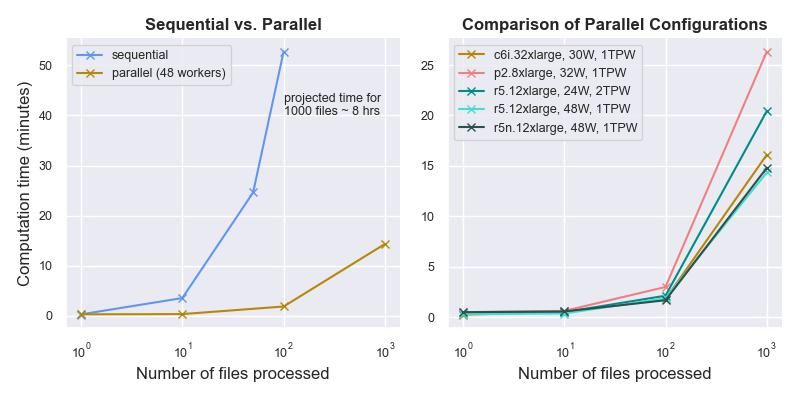

**Figure 1**

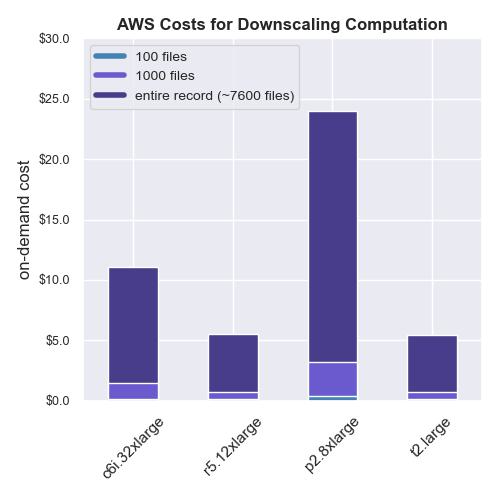

## Summary

About 50% decrease in computation time with 2 workers (gut check passed)

**Other notes**

On the t2.xlarge (4 vCPUs, ~16 GiB memory)
* having 4 workers with 4 threads fails, 
* having 2 workers with 4 threads succeeds but takes the same amount of time as sequential computation,

**Other Suggestions/Guidance**
* Having extra memory (or memory per worker) beyond what is required to perform the computation does not speed up the computation.
* Garbage collection and variable deletion after completed computations are important in order to not run out of memory.
* Drop variables argument for xarray.open_dataset (try it with the .py file and an EC2 instance)?
